In [1]:
import sys
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

In [9]:
dir_atlas = join(dir_git,'SeqSpatialSupp_fMRI/atlas/fs_LR_32k')
border = simage.get_border(join(dir_git,'surfAnalysisPy'))

---

# GLM2

|  | trial $_{t-1}$ | trial $_{t}$ |
|---------|---------|---------|
| Both-Rep| $(i,j)$ | $(i,j)$ |
| Cue-Rep | $(i,\neg j)$ | $(i,j)$ |
| Seq-Rep | $(\neg i,j)$ | $(i,j)$ |
| NRep    | $(\neg i,\neg j)$ | $(i,j)$ |

$TS=(i,j)$

$ j=1: Letter $, $ j=2: Spatial $

$ i=1: 32451 $, $ i=2: 35124 $, $i=3: 13254 $, $ i=4: 14523$

In [10]:
glm = 2
dir_glm = su.get_dir_glm(glm)

In [11]:
subj = 'S01'

In [12]:
# reginfo = deal_spm.load_reginfo(subj, glm)
# reginfo

---

## Design Matrix

In [13]:
SPM = join(dir_glm, subj, 'SPM.mat')

# X = deal_spm.get_SPM_X(SPM, run=1)
# X.shape

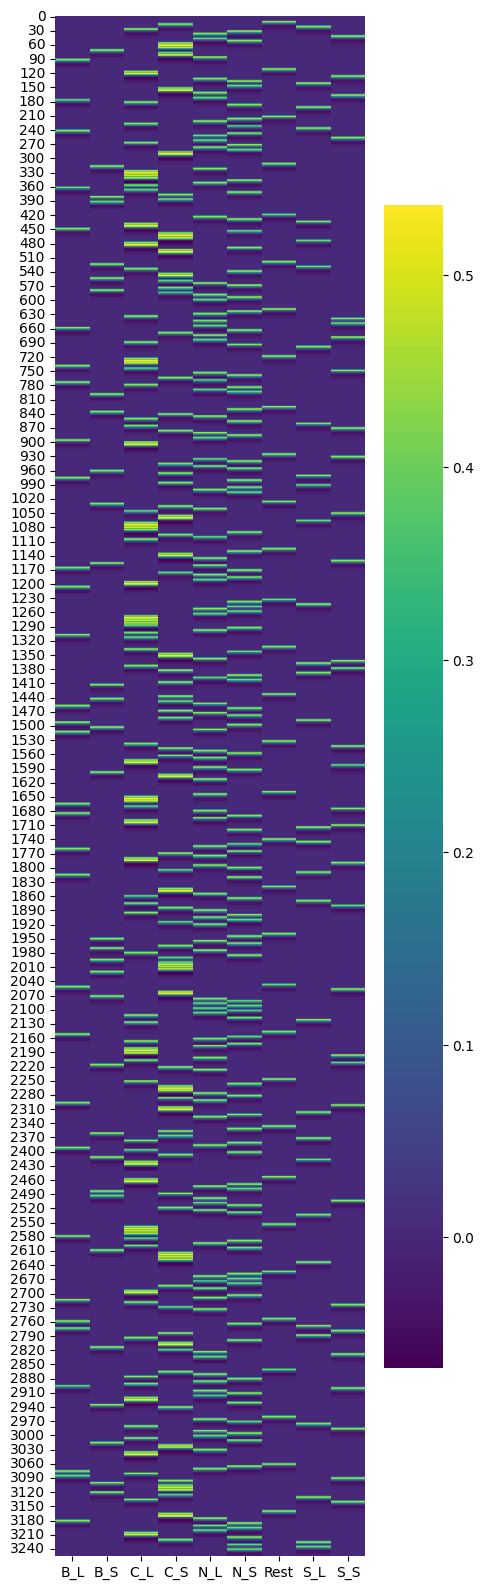

In [14]:
fig, ax = plt.subplots(figsize=(5,20))

df_X = deal_spm.get_df_X(SPM)
g = sns.heatmap(df_X.drop(columns=['TR','Run']), cmap=cm.viridis, ax=ax)

# dir_work = join(su.get_dir_result())
# fig.savefig(
#     join(dir_work,'glm2.design_X.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

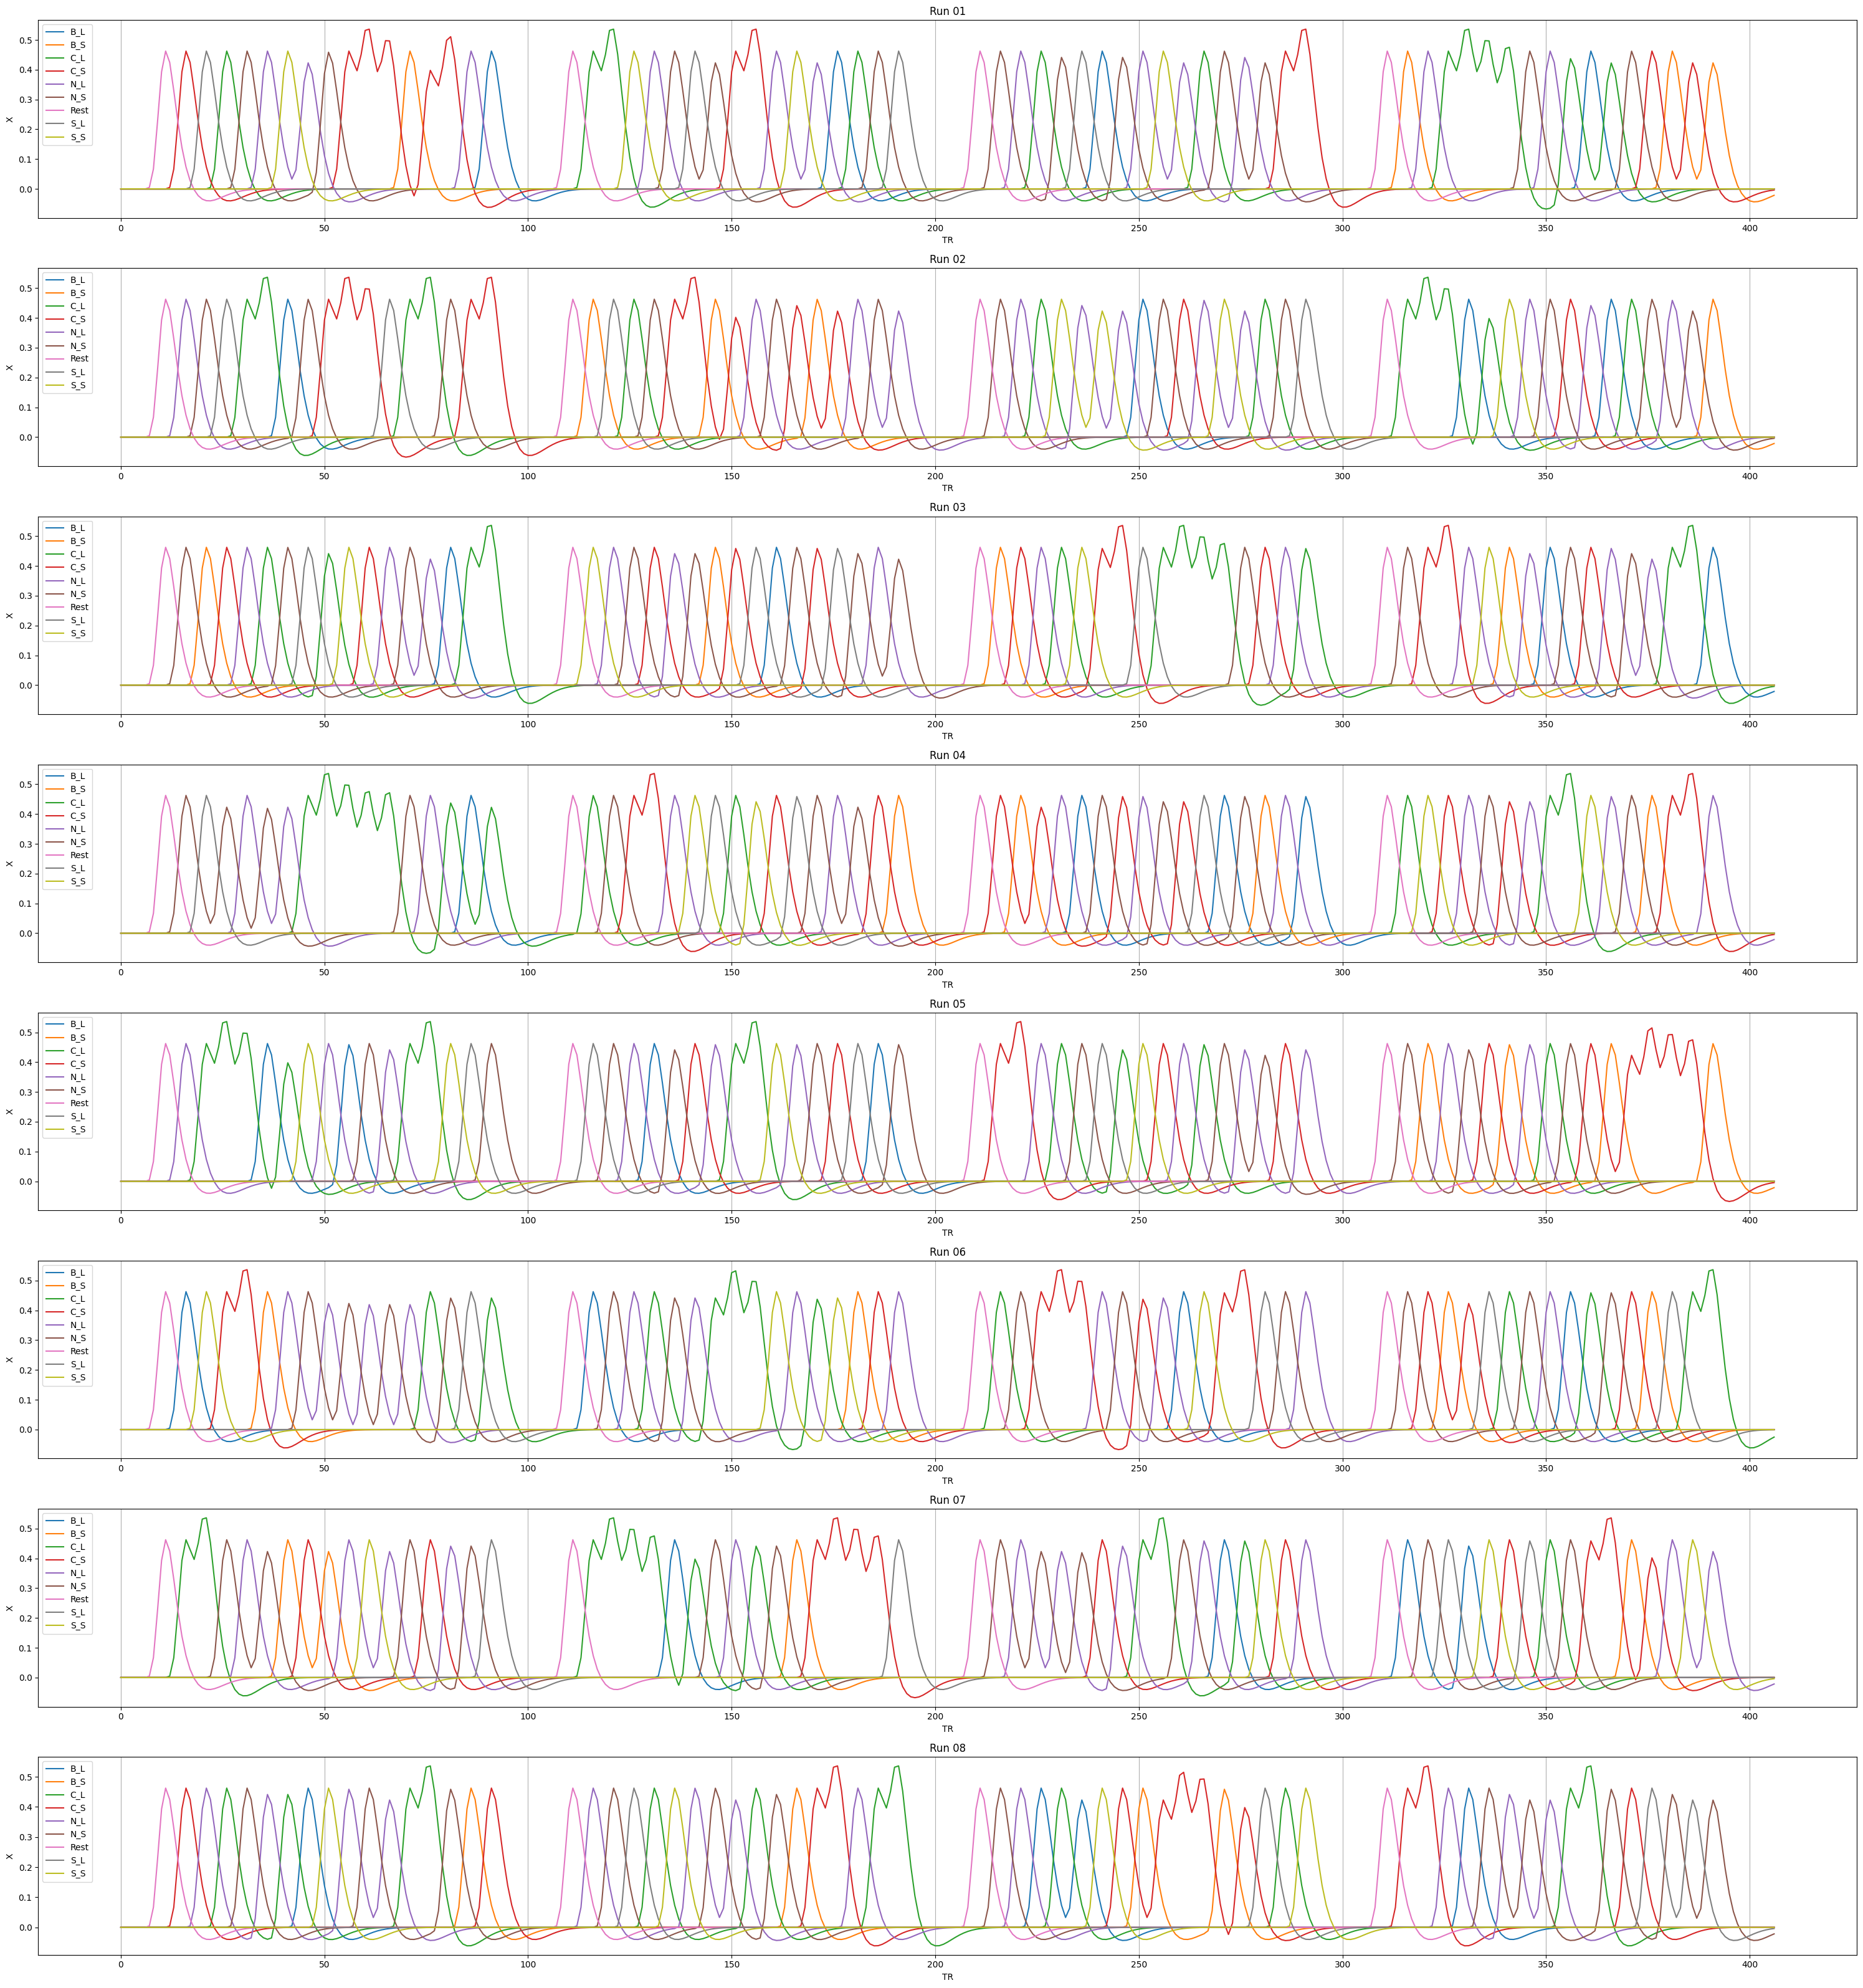

In [15]:
nrows = 8
fig, axs = plt.subplots(nrows=nrows, figsize=(30,4*nrows))

df_X = deal_spm.get_df_X(SPM, melt=True)

for rr in range(8):
    run = rr+1
    g = sns.lineplot(
        data=df_X[df_X.Run==run],
        x='TR', y='X', 
        hue='reg',
        ax=axs[rr]
    )
    g.grid(axis='x')
    g.legend(loc='upper left')
    g.set_title('Run %02d'%run)

fig.tight_layout()
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
fig.savefig(
    join(dir_work,'glm%d.design_X.%s.png'%(glm,subj)),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

---

## Contrast

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
C & \textcolor{gray}{B} & C & C & N & S & N & N \\
C & C & \textcolor{gray}{B} & C & N & N & S & N \\
C & C & C & \textcolor{gray}{B} & N & N & N & S \\
S & N & N & N & \textcolor{gray}{B} & C & C & C \\
N & S & N & N & C & \textcolor{gray}{B} & C & C \\
N & N & S & N & C & C & \textcolor{gray}{B} & C \\
N & N & N & S & C & C & C & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
1. B: both of cue and sequence repetition (8 trials)
2. S: only sequence repetition (8 trials)
3. C: only cue repetition (24 trials)
4. N: no repetition (24 trials)

In [16]:
dir_surf = su.get_dir_surf()
hemi = 'L'

In [17]:
dir_work = join(dir_surf,'glm_%d'%glm)

- Conditions:
    1. BothRep_L (B)
    2. BothRep_S (B)
    3. CueRep_L (C)
    4. CueRep_S (C)
    5. NonRep_L (N)
    6. NonRep_S (N)
    7. Rest (1st trials of each block, no-interest)
    8. SeqRep_L (S)
    9. SeqRep_S (S)

- Contrasts:
    1. BothRep_L:  $c=[1\ 0\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    2. BothRep_S:  $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    3. CueRep_L:   $c=[0\ 0\ 1\ 0\ 0\ 0\ 0\ 0\ 0]$
    4. CueRep_S:   $c=[0\ 0\ 0\ 1\ 0\ 0\ 0\ 0\ 0]$
    5. NonRep_L:   $c=[0\ 0\ 0\ 0\ 1\ 0\ 0\ 0\ 0]$
    6. NonRep_S:   $c=[0\ 0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]$
    7. SeqRep_L:   $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 1\ 0]$
    8. SeqRep_S:   $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 0\ 1]$
    9. wRS_L:      $c=[1\ 0\ \!-\!1\ 0\ 0\ 0\ 0\ 0\ 0]$
    10. wRS_S:     $c=[0\ 1\ 0\ \!-\!1\ 0\ 0\ 0\ 0\ 0]$
    11. wRS_L-S:   $c=$ (wRS_L - wRS_S)$*0.5$
    12. acRS_L:    $c=[0\ 0\ 0\ 0\ \!-\!1\ 0\ 0\ 1\ 0]$
    13. acRS_S:    $c=[0\ 0\ 0\ 0\ 0\ \!-\!1\ 0\ 0\ 1]$
    14. acRS-L-S:  $c=$ (acRS_L - acRS_S)$*0.5$
    15. Letter:    $c=[1\ 0\ 1\ 0\ 1\ 0\ 1\ 0\ 0\ 0]*0.25$
    16. Spatial:   $c=[0\ 1\ 0\ 1\ 0\ 1\ 0\ 0\ 1\ 0]*0.25$
    17. L-S:       $c=[1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 1\ 0\ \!-\!1\ 0]*0.25$

- Calculation:
    $$ \vec{c}\cdot\vec{\beta}=d $$

In [18]:
fnames = glob(join(dir_work,'???.%s.glm_%d.t.func.gii'%(hemi,glm)))
len(fnames)

24

In [19]:
alpha = 0.05
thresh = scipy.stats.t.ppf(1-0.5*alpha,df=len(fnames)-1)
print(thresh)

2.0686576104190406


In [20]:
orders = simage.load_contrast_order(subj,glm,map='t')
orders

array(['spmT_B_L.nii', 'spmT_B_S.nii', 'spmT_C_L.nii', 'spmT_C_S.nii',
       'spmT_Letter-Spatial.nii', 'spmT_Letter.nii', 'spmT_N_L.nii',
       'spmT_N_S.nii', 'spmT_Rest.nii', 'spmT_S_L.nii', 'spmT_S_S.nii',
       'spmT_Spatial.nii', 'spmT_acRS_L-S.nii', 'spmT_acRS_L.nii',
       'spmT_acRS_S.nii', 'spmT_wRS_L-S.nii', 'spmT_wRS_L.nii',
       'spmT_wRS_S.nii'], dtype='<U23')

### i) Task-related activity

In [29]:
vmin, vmax = -10, 10

In [30]:
idxs = [5, 11, 4]
for idx in idxs:
    cond = orders[idx]
    print(cond)

spmT_Letter.nii
spmT_Spatial.nii
spmT_Letter-Spatial.nii


Individual

In [31]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
makedirs(dir_work, exist_ok=True)

ncols = len(idxs)
for fname in tqdm(fnames):
    subj = fname.split('/')[-1].split('.')[0]
    gii = nb.load(fname)
    
    fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))
    for ii, idx in enumerate(idxs):
        ax = axs[ii]
        plt.sca(ax)
        
        data = gii.darrays[idx].data
        cond = orders[idx]
        
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_%s'%hemi,
            alpha=0.7,
            cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
            threshold=thresh,
            borders=border, bordercolor='black', bordersize=3,
            overlay_type='func', render='matplotlib'
        )
        x, y = 50, 250
        g.text(
            x=x, y=y,
            s=cond,
            ha='center', va='center',
            fontsize=16
        )
    fig.suptitle('%s (p<%.2f)'%(subj,alpha), fontsize=18)
    fig.savefig(
        join(dir_work,'glm%d.contrast.tval.%s.task_activity.png'%(glm,subj)),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )
    plt.close()

100%|███████████████████████████████████████████████████| 24/24 [06:37<00:00, 16.56s/it]


Group

spmT_Letter.nii
spmT_Spatial.nii
spmT_Letter-Spatial.nii


Text(0.5, 0.98, 'p<0.05')

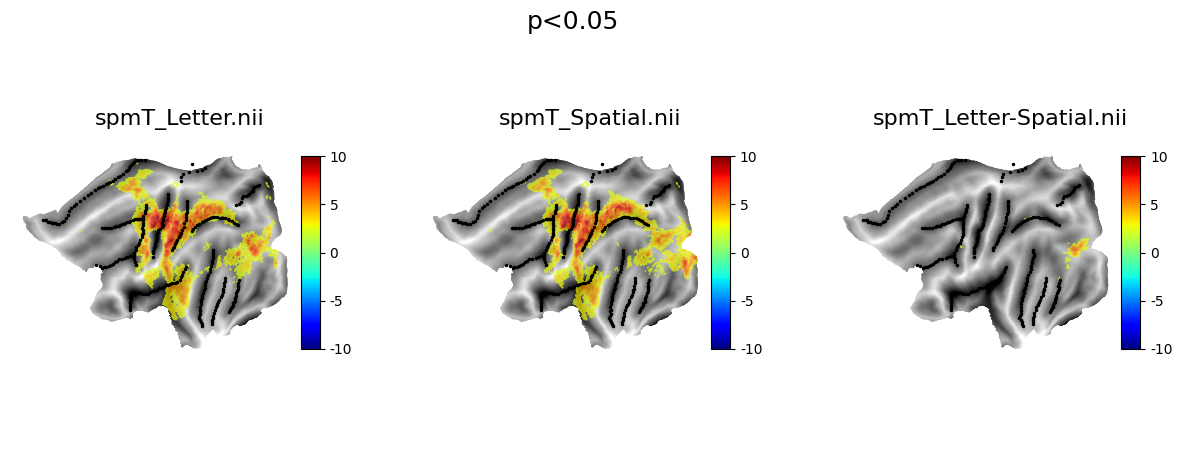

In [37]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
        threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )
    
    x, y = 50, 250
    g.text(
        x=x, y=y,
        s=cond,
        ha='center', va='center',
        fontsize=16
    )
fig.suptitle('p<%.2f'%alpha, fontsize=18)

In [24]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
fig.savefig(
    join(dir_work,'glm%d.contrast.tval.n%d.activity.png'%(glm,len(fnames))),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

### ii) Within

In [21]:
vmin, vmax = -2, 2

In [22]:
idxs = [16, 17, 15]
for idx in idxs:
    cond = orders[idx]
    print(cond)

spmT_wRS_L.nii
spmT_wRS_S.nii
spmT_wRS_L-S.nii


Individual

In [35]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
makedirs(dir_work, exist_ok=True)

ncols = len(idxs)
for fname in tqdm(fnames):
    subj = fname.split('/')[-1].split('.')[0]
    gii = nb.load(fname)
    
    fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))
    for ii, idx in enumerate(idxs):
        ax = axs[ii]
        plt.sca(ax)
        
        data = gii.darrays[idx].data
        cond = orders[idx]
        
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_%s'%hemi,
            alpha=0.7,
            cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
            threshold=thresh,
            borders=border, bordercolor='black', bordersize=3,
            overlay_type='func', render='matplotlib'
        )
        x, y = 50, 250
        g.text(
            x=x, y=y,
            s=cond,
            ha='center', va='center',
            fontsize=16
        )
    fig.suptitle('%s (p<%.2f)'%(subj,alpha), fontsize=18)
    fig.savefig(
        join(dir_work,'glm%d.contrast.tval.%s.wRS.png'%(glm,subj)),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )
    plt.close()

100%|███████████████████████████████████████████████████| 24/24 [06:24<00:00, 16.00s/it]


Group

spmT_wRS_L.nii
spmT_wRS_S.nii
spmT_wRS_L-S.nii


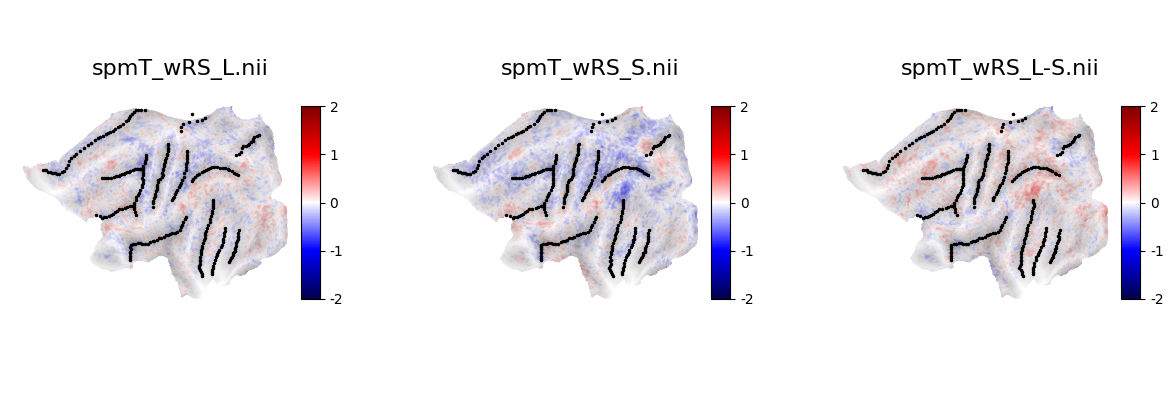

In [23]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
        # threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )
    
    x, y = 50, 250
    g.text(
        x=x, y=y,
        s=cond,
        ha='center', va='center',
        fontsize=16
    )
# fig.suptitle('p<%.2f'%alpha, fontsize=18)

In [24]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
fig.savefig(
    join(dir_work,'glm%d.contrast.tval.n%d.wRS.png'%(glm,len(fnames))),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

### iii) Across

In [24]:
vmin, vmax = -2, 2

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [25]:
idxs = [13, 14, 12]
for idx in idxs:
    cond = orders[idx]
    print(cond)

spmT_acRS_L.nii
spmT_acRS_S.nii
spmT_acRS_L-S.nii


Individual

In [43]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
makedirs(dir_work, exist_ok=True)

ncols = len(idxs)
for fname in tqdm(fnames):
    subj = fname.split('/')[-1].split('.')[0]
    gii = nb.load(fname)
    
    fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))
    for ii, idx in enumerate(idxs):
        ax = axs[ii]
        plt.sca(ax)
        
        data = gii.darrays[idx].data
        cond = orders[idx]
        
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_%s'%hemi,
            alpha=0.7,
            cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
            threshold=thresh,
            borders=border, bordercolor='black', bordersize=3,
            overlay_type='func', render='matplotlib'
        )
        x, y = 50, 250
        g.text(
            x=x, y=y,
            s=cond,
            ha='center', va='center',
            fontsize=16
        )
    fig.suptitle('%s (p<%.2f)'%(subj,alpha), fontsize=18)
    fig.savefig(
        join(dir_work,'glm%d.contrast.tval.%s.acRS.png'%(glm,subj)),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )
    plt.close()

100%|███████████████████████████████████████████████████| 24/24 [06:31<00:00, 16.33s/it]


Group

spmT_acRS_L.nii
spmT_acRS_S.nii
spmT_acRS_L-S.nii


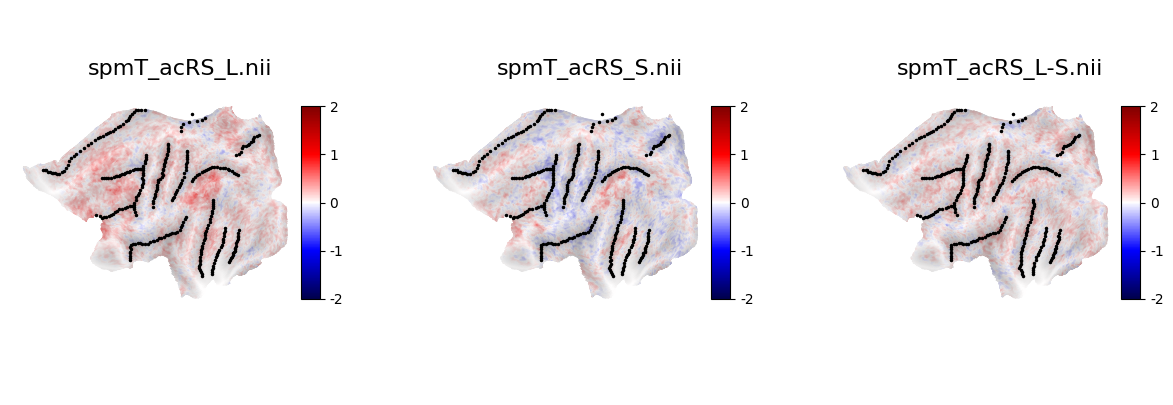

In [26]:
ncols = len(idxs)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

for ii, idx in enumerate(idxs):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = orders[idx]
    print(cond)

    dataset = []
    for fname in fnames:
        gii = nb.load(fname)
        data = gii.darrays[idx].data
        dataset.append(data)
    dataset = np.array(dataset)
    
    g = surf.plot.plotmap(
        data=dataset.mean(axis=0),
        surf='fs32k_%s'%hemi,
        alpha=0.7,
        cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
        # threshold=thresh,
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib'
    )
    
    x, y = 50, 250
    g.text(
        x=x, y=y,
        s=cond,
        ha='center', va='center',
        fontsize=16
    )
# fig.suptitle('p<%.2f'%alpha, fontsize=18)

In [28]:
dir_work = join(su.get_dir_result(),'glm_%d'%glm)
fig.savefig(
    join(dir_work,'glm%d.contrast.tval.n%d.acRS.png'%(glm,len(fnames))),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

---

## Percent Signal Change

---